# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 2](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition

This task aims to categorize the sexist messages according to the intention of the author in one of the following categories: (i) direct sexist message, (ii) reported sexist message and (iii) judgemental message.

### Examples:

#### DIRECT 
The intention was to write a message that is sexist by itself or incites to be sexist, as in:

''*A woman needs love, to fill the fridge, if a man can give this to her in return for her services (housework, cooking, etc), I don’t see what else she needs.*''

#### REPORTED
The intention is to report and share a sexist situation suffered by a woman or women in first or third person, as in:

''*Today, one of my year 1 class pupils could not believe he’d lost a race against a girl.*''

#### JUDGEMENTAL
The intention was to judge, since the tweet describes sexist situations or behaviours with the aim of condemning them.

''*As usual, the woman was the one quitting her job for the family’s welfare…*''

# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2025-2026/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.


### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are label for multiple tasks, but we are focusing on **Task 2**.
- For Task 2, label are assigned by six annotators.
- The label for Task 2 represent whether the tweet is non-sexist ('-') or its sexist intention ('DIRECT', 'REPORTED', 'JUDGEMENTAL').







### Example

```
    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "label_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }
```

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as ``pandas.DataFrame``.
3. **Aggregate labels** for Task 2 using majority voting and store them in a new dataframe column called `label`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `label`.
6. **Encode the `label` column**: Use the following mapping

```
{
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}
```

In [94]:
from collections import Counter
import json
from pathlib import Path
import pandas as pd
import re
import unicodedata
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

In [95]:
path_train = "data/training.json"
df_train = pd.read_json(path_train)
df_train = df_train.reset_index(drop=False).rename(columns={"index": "key"}).transpose()
df_train.columns = df_train.iloc[0]
df_train = df_train[1:]
df_train.head()
print(f"Loaded {len(df_train)} records from {path_train}")
# df_train.head()

path_test = "data/test.json"
df_test = pd.read_json(path_test)
df_test = df_test.reset_index(drop=False).rename(columns={"index": "key"}).transpose()
df_test.columns = df_test.iloc[0]
df_test = df_test[1:]
df_test.head()
print(f"Loaded {len(df_test)} records from {path_test}")
# df_test.head()

path_val = "data/validation.json"
df_val = pd.read_json(path_val)
df_val = df_val.reset_index(drop=False).rename(columns={"index": "key"}).transpose()
df_val.columns = df_val.iloc[0]
df_val = df_val[1:]
df_val.head()
print(f"Loaded {len(df_val)} records from {path_val}")
# df_val.head()

Loaded 6920 records from data/training.json
Loaded 312 records from data/test.json
Loaded 726 records from data/validation.json


In [96]:
df_val.head()

key,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
300001,300001,es,@Fichinescu La comunidad gamer es un antro de ...,6,"[Annotator_726, Annotator_727, Annotator_357, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, NO, YES, NO]","[-, JUDGEMENTAL, JUDGEMENTAL, -, REPORTED, -]","[[-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [MISOGYN...",DEV_ES
300002,300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, NO, YES, YES, YES]","[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,6,"[Annotator_735, Annotator_736, Annotator_345, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,300004,es,Also mientras les decia eso la señalaba y deci...,6,"[Annotator_259, Annotator_739, Annotator_291, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,300005,es,"And all people killed, attacked, harassed by ...",6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, NO, NO]","[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES


In [97]:
df_test.head()

key,id_EXIST,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
400178,400178,en,1st day at the pool on a beautiful Sunday in N...,6,"[Annotator_764, Annotator_765, Annotator_766, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400179,400179,en,“I like your outfit too except when i dress up...,6,"[Annotator_805, Annotator_426, Annotator_806, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, NO]","[JUDGEMENTAL, DIRECT, REPORTED, DIRECT, REPORT...","[[OBJECTIFICATION], [OBJECTIFICATION, MISOGYNY...",DEV_EN
400180,400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400181,400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, DIRECT, JUDGEMENTAL, DIRECT, DIRECT, DIRECT]","[[-], [IDEOLOGICAL-INEQUALITY, MISOGYNY-NON-SE...",DEV_EN
400182,400182,en,@ultshunnie u gotta say some shit like “i’ll f...,6,"[Annotator_770, Annotator_771, Annotator_772, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, YES]","[DIRECT, REPORTED, DIRECT, DIRECT, JUDGEMENTAL...","[[OBJECTIFICATION, SEXUAL-VIOLENCE], [SEXUAL-V...",DEV_EN


We added the 'secondary_label' column in which are stored, for each tweet, the second most common label given by the annotators. We're going to compare it with the predicted label later in the error analysis.

In [98]:
# Adding the new column 'label'
def most_common_label(labels):

    if ((len(Counter(labels))>1) and (Counter(labels).most_common(1)[0][1] == Counter(labels).most_common(2)[1][1])):
        return pd.NA
    # print(Counter(labels).most_common(2))
    return Counter(labels).most_common(1)[0][0]

def secondary_most_common_label(labels):

    if ((len(Counter(labels))>1) and (Counter(labels).most_common(1)[0][1] == Counter(labels).most_common(2)[1][1])):
        return pd.NA
    elif (len(Counter(labels))<2): 
        return pd.NA
    return Counter(labels).most_common(2)[1][0]

# Populating the new column with the most common label for each row
df_train['label'] = df_train['labels_task2'].apply(most_common_label)
df_test['label'] = df_test['labels_task2'].apply(most_common_label)
df_test['secondary_label'] = df_test['labels_task2'].apply(secondary_most_common_label)
df_val['label'] = df_val['labels_task2'].apply(most_common_label)

# Deleting all the rows with no most common label
df_train_dropna = df_train.dropna(subset=['label'])    
df_test_dropna = df_test.dropna(subset=['label'])    
df_val_dropna = df_val.dropna(subset=['label'])

# Filtering only English tweets and selecting relevant columns
df_train_en = df_train_dropna[df_train_dropna['lang'] == 'en'][['id_EXIST','tweet','label']]
# we add the secondary label just in the test set
df_test_en = df_test_dropna[df_test_dropna['lang']=='en'][['id_EXIST','tweet','label', 'secondary_label']]
df_val_en = df_val_dropna[df_val_dropna['lang']=='en'][['id_EXIST','tweet','label']]



In [99]:
df_test_en.head()

key,id_EXIST,tweet,label,secondary_label
400178,400178,1st day at the pool on a beautiful Sunday in N...,-,<NA>
400180,400180,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",-,<NA>
400181,400181,@themaxburns @GOP Fuck that cunt. Tried to vot...,DIRECT,-
400182,400182,@ultshunnie u gotta say some shit like “i’ll f...,DIRECT,REPORTED
400183,400183,"@FernsLewds “Mmm, fuck that cunt is hungry for...",DIRECT,-


In [100]:
# Mapping labels to integers
mapping = {
    '-': 0,
    'DIRECT': 1,
    'JUDGEMENTAL': 2,
    'REPORTED': 3
}

df_train_en['label'] = df_train_en['label'].map(mapping)
df_test_en['label'] = df_test_en['label'].map(mapping)
df_val_en['label'] = df_val_en['label'].map(mapping)


In [101]:
train_df = df_train_en
val_df = df_val_en
test_df = df_test_en

In [102]:
# Save the processed dataframes for future tasks
train_df.to_csv('processed_train.csv', index=False)
val_df.to_csv('processed_validation.csv', index=False)
test_df.to_csv('processed_test.csv', index=False)


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [103]:
from collections import Counter
import json
from pathlib import Path
import pandas as pd
import re
import unicodedata
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize

from spellchecker import SpellChecker

### Defining dataframes

In [104]:
# Task 2 - Data Cleaning
# Download required NLTK data
print("Downloading NLTK resources...")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

train_df = pd.read_csv('processed_train.csv')
val_df = pd.read_csv('processed_validation.csv')
test_df = pd.read_csv('processed_test.csv')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Cleaning

In [105]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
spell = SpellChecker()

# CLEANING FUNCTION
def clean_tweet(tweet, spell_check=False):
    """
    Clean and preprocess a tweet by removing unwanted elements and performing lemmatization
    """
    if pd.isna(tweet):
        return ""
    
    # Convert to string if not already
    tweet = str(tweet)

    # Remove emojis and emoticons
    # First pattern: remove common emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"  # Misc symbols
                           u"\U000024C2-\U0001F251"  # Enclosed characters 
                           "]+", flags=re.UNICODE)
    tweet = emoji_pattern.sub('', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)   

    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove special characters and symbols. Keep letters, numbers, and basic punctuation (.!?)
    tweet = re.sub(r'([.!?])', r' \1 ', tweet)
    tweet = re.sub(r'[^\w\s.!?]', ' ', tweet)

    tweet = re.sub(r"(.)\1{2,}", r"\1\1", tweet)

    # Remove specific quote characters
    tweet = re.sub(r'[“”‘’"\']', '', tweet)
    
    # Tokenize and lemmatize
    tokens = word_tokenize(tweet)
    lemmatized_tokens = []
    
    for token in tokens:
        if token.isalpha():
            if spell_check:
                spell.correction(token)
            token = token.lower() or token
            # Lemmatize (try noun first,verb, then adjectives)
            lemma = lemmatizer.lemmatize(token, pos='n')  # noun
            lemma = lemmatizer.lemmatize(lemma, pos='v')           # verb
            lemma = lemmatizer.lemmatize(lemma, pos='a')          # adjective
            lemmatized_tokens.append(lemma)
        else:
            lemmatized_tokens.append(token)
    
    # Rejoin tokens
    cleaned_tweet = ' '.join(lemmatized_tokens)
    
    # Remove extra whitespace
    cleaned_tweet = re.sub(r'\s+', ' ', cleaned_tweet).strip() 
    
    return cleaned_tweet

In [106]:
# Apply cleaning 
train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
val_df['tweet'] = val_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)

### Sample visualization

In [107]:
sample_indices = [0, 5, 10]  # Sample indices to display

for idx in sample_indices:
    if idx < len(train_df):
        
        print(f"Example {idx + 1}:")
        print( train_df.iloc[idx]['tweet'])
        print("-" * 80)

Example 1:
ffs ! how about lay the blame on the bastard who murder her ? novel idea i know .
--------------------------------------------------------------------------------
Example 6:
accord to a customer i have plenty of time to go spend the stirling coin he want to pay me with in derry . just like any other woman i m sure of it . in retail .
--------------------------------------------------------------------------------
Example 11:
mean woman usually end up in low pay support work when that start to change traditionalist notice unfairness that previously hasn t bother them at all .
--------------------------------------------------------------------------------


Saving csv's to avoid rerunning cleaning

In [108]:
train_df.to_csv('cleaned_train.csv', index=False)
val_df.to_csv('cleaned_validation.csv', index=False)
test_df.to_csv('cleaned_test.csv', index=False)

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




In [109]:
from collections import Counter
import json
from pathlib import Path
import pandas as pd
import re
import unicodedata
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from spellchecker import SpellChecker
import gensim

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., ``<UNK>``) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

Reading the cleaned .csv files

In [110]:
# Task 3 - Text Encoding with GloVe Embeddings
import numpy as np
from collections import defaultdict
from collections import OrderedDict
import requests
import os
import zipfile
from tqdm import tqdm
import gensim
import gensim.downloader as gloader
from typing import List, Callable, Dict

# Load cleaned datasets
train_df = pd.read_csv('cleaned_train.csv')
val_df = pd.read_csv('cleaned_validation.csv')
test_df = pd.read_csv('cleaned_test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 2873
Validation samples: 150
Test samples: 280


Defining a function to load an embedding model

In [111]:
def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [112]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
# Fasttext -> 300

embedding_dimension = 100

embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=embedding_dimension )

Defining a function for building the vocabulary

In [113]:
def build_vocabulary(df: pd.DataFrame) -> (Dict[int, str], Dict[str, int], List[str]):
 
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    # reserve special tokens
    word_to_idx['<PAD>'] = 0
    idx_to_word[0] = '<PAD>'
    word_to_idx['<UNK>'] = 1
    idx_to_word[1] = '<UNK>'

    
    curr_idx = 2  # start from 2 to reserve 0 for <PAD> and 1 fro <UNK>
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

Building our vocabulary, checking its size and printing some words 

In [114]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(train_df)

print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')

some_words = [(idx_to_word[idx], idx) for idx in np.arange(10) ]
print(f'[Debug] Some words: {some_words}')

vocab_size = len(word_to_idx)

100%|██████████| 2873/2873 [00:00<00:00, 60084.74it/s]

[Debug] Index -> Word vocabulary size: 8671
[Debug] Word -> Index vocabulary size: 8671
[Debug] Some words: [('<PAD>', np.int64(0)), ('<UNK>', np.int64(1)), ('ffs', np.int64(2)), ('!', np.int64(3)), ('how', np.int64(4)), ('about', np.int64(5)), ('lay', np.int64(6)), ('the', np.int64(7)), ('blame', np.int64(8)), ('on', np.int64(9))]


In [115]:
print("gangbanged" in word_listing)

True


### Inspecting OOVs

Checking which terms are OOV and checking the percentage of OOV terms in our vocabulary

In [116]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):

    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [117]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

oov_sample = oov_terms[:30]
print(f"Some OOV terms: {oov_sample}")

Total OOV terms: 960 (11.07%)
Some OOV terms: ['tiktok', 'waater', 'Ep01', 'intwrvewers', 'highlp', 'sfprice', 'astrodomina', 'maaybe', 'casteist', 'wabt', 'makhulu', 'erens', '25inch', 'seatcomment', 'kikyuuseinfact', 'go2', 'ekyo', 'matteri', 'librel', 'onea', 'apko', 'sofoulis', 'maaster', 'androcentrism', 'afterpay', 'suburan', 'nyjc', 'bidmc', 'feminazis', 'alotta']


### Building embedding matrix

In [118]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int,
                           oov_terms: List[str]) -> np.ndarray:

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    rng = np.random.RandomState(seed=12345)

    # Fill embeddings but do NOT overwrite PAD (idx==0)
    for word, idx in tqdm(word_to_idx.items()):
        if idx == 0:
            # keep PAD as zero vector for mask_zero=True
            continue
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = rng.uniform(low=-0.05, high=0.05, size=embedding_dimension).astype(np.float32)

        embedding_matrix[idx] = embedding_vector

    # Set a stable <UNK> vector (mean of known embeddings) if available
    unk_idx = word_to_idx.get('<UNK>', None)
    if unk_idx is not None and unk_idx != 0:
        # average only non-zero rows (skip PAD)
        non_zero_mask = np.linalg.norm(embedding_matrix, axis=1) > 0
        if non_zero_mask.sum() > 0:
            embedding_matrix[unk_idx] = embedding_matrix[non_zero_mask].mean(axis=0).astype(np.float32)
        else:
            # fallback
            embedding_matrix[unk_idx] = rng.uniform(low=-0.05, high=0.05, size=embedding_dimension).astype(np.float32)

    return embedding_matrix

In [119]:
# Testing
embedding_dimension = 100
# embedding_dimension is defined also previously when uploading GloVe, these two parameters must match
embedding_matrix = build_embedding_matrix(embedding_model,
                                          embedding_dimension,
                                          word_to_idx,
                                          vocab_size,
                                          oov_terms)
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 8671/8671 [00:00<00:00, 66955.36it/s]

Embedding matrix shape: (8671, 100)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* **Stacked**: add an additional Bidirectional LSTM layer to the Baseline model.

**Note**: You are **free** to experiment with hyper-parameters.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape ``(batch_size, # tokens, embedding_dim)`` to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

### Embedding model definition

In [121]:
train_maxlen = max([len(train_df['tweet'][i].split()) for i in range(len(train_df))])
val_maxlen = max([len(val_df['tweet'][i].split()) for i in range(len(val_df))])
test_maxlen = max([len(test_df['tweet'][i].split()) for i in range(len(test_df))])

max_len = max(train_maxlen, val_maxlen, test_maxlen)
print(f"Max tweet length after cleaning: {max_len} tokens")

Max tweet length after cleaning: 71 tokens


In [ ]:
# I chose the 'embedding layer' option

embedding = Embedding(input_dim=vocab_size,
                        output_dim=embedding_dimension,
                        weights=[embedding_matrix],
                        mask_zero=True,    # automatically masks padding tokens
                        trainable = False, # to freeze the embeddings during training
                        name='encoder_embedding')

embedding(tf.zeros((1, max_len), dtype=tf.int32));

<tf.Tensor: shape=(1, 71, 100), dtype=float32, numpy=
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)>

############################################################################################

############################################################################################

Run from here to avoid dwnloading GLoVe

## Baseline model definition

In [193]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

In [194]:
# model definition
def build_baseline():
    baseline_model = Sequential([
        # embedding layer
        embedding,
        # Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=False)),
        # Output layer
        Dense(4, activation='softmax')
    ])
    return baseline_model

In [195]:
baseline_model = build_baseline()
baseline_model.build(input_shape=(None, max_len))
baseline_model.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)   │ (None, 71, 100)        │       867,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_67                │ (None, 128)            │        84,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 952,096 (3.63 MB)

 Trainable params: 84,996 (332.02 KB)

 Non-trainable params: 867,100 (3.31 MB)

## Stacked model definition

In [196]:
# model definition
def build_stacked():
    stacked_model = Sequential([
        # embedding layer
        embedding,
        # 1st Bidirectional LSTM layer
        Bidirectional(LSTM(64, return_sequences=True)),
        # 2nd Bidirectional LSTM layer
        Bidirectional(LSTM(32)),
        # Output layer
        Dense(4, activation='softmax')
    ])
    return stacked_model


In [197]:
# we build a model just to check its summary
stacked_model = build_stacked()
stacked_model.build(input_shape=(None, max_len))
stacked_model.summary()

Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)   │ (None, 71, 100)        │       867,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_68                │ (None, 71, 128)        │        84,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_69                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 993,056 (3.79 MB)

 Trainable params: 125,956 (492.02 KB)

 Non-trainable params: 867,100 (3.31 MB)

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Stacked models.



### Instructions

* Pick **at least** three seeds for robust estimation.
* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute macro F1-score, precision, and recall metrics on the validation set.
* Report average and standard deviation measures over seeds for each metric.
* Pick the **best** performing model according to the observed validation set performance (use macro F1-score).

In [198]:
train_df.head()

,id_EXIST,tweet,label
0,200001,ffs ! how about lay the blame on the bastard w...,0
1,200002,write a uni essay in my local pub with a coffe...,3
2,200003,it be 2021 not 1921 . i dont appreciate that o...,3
3,200004,this be unacceptable . use her title a you do ...,0
4,200005,make yourself a hard target basically boil dow...,0


### Preparing train and validation sets

In [199]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def texts_to_padded_sequences(texts, word_to_idx, max_len=71, pad_value=0):
    unk_id = word_to_idx.get('<UNK>', None)
    seqs = []
    for t in texts:
        ids = []
        for tok in str(t).split():
            idx = word_to_idx.get(tok, unk_id)
            if idx is None:
                idx = pad_value
            ids.append(idx)
        seqs.append(ids)
    if max_len is None:
        max_len = max((len(s) for s in seqs), default=0)
    arr = pad_sequences(seqs, maxlen=max_len, padding='post', truncating='post', value=pad_value)
    return np.asarray(arr, dtype=np.int32)


# build arrays
X_train = texts_to_padded_sequences(train_df['tweet'].values, word_to_idx)
X_val   = texts_to_padded_sequences(val_df['tweet'].values,   word_to_idx)
X_test  = texts_to_padded_sequences(test_df['tweet'].values,  word_to_idx)

y_train = train_df['label'].values.astype(np.int32)
y_val   = val_df['label'].values.astype(np.int32)
y_test  = test_df['label'].values.astype(np.int32)

print(f'Train input shape:      {X_train.shape},    Train labels shape: {y_train.shape}')
print(f'Validation input shape: {X_val.shape},      Validation labels shape: {y_val.shape}')
print(f'Test input shape:       {X_test.shape},     Test labels shape: {y_test.shape}')

Train input shape:      (2873, 71),    Train labels shape: (2873,)
Validation input shape: (150, 71),      Validation labels shape: (150,)
Test input shape:       (280, 71),     Test labels shape: (280,)


In [200]:
# Training: add callbacks and class weights
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

os.makedirs('checkpoints', exist_ok=True)

# compute balanced class weights
cls = np.unique(y_train)
cw = class_weight.compute_class_weight('balanced', classes=cls, y=y_train)
class_weight_dict = {int(k): float(v) for k, v in zip(cls, cw)}

### Plotting function

In [201]:
#plottig function

import matplotlib.pyplot as plt

def plot_train_val_loss(history, label='Model', save_path=None):
    # accept Keras History object or a plain dict
    hist = history.history if hasattr(history, 'history') else history
    loss = hist.get('loss')
    val_loss = hist.get('val_loss')
    if loss is None:
        raise ValueError("history does not contain 'loss' key")
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(7,4))
    plt.plot(epochs, loss, 'o-', label=f'{label} train')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 's--', label=f'{label} val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{label} loss')
    plt.grid(True)
    plt.legend()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

### Baseline Model Training

In [210]:
import random

random_seed1 = 42
random_seed2 = 1312
random_seed3 = 1234

seeds = [random_seed1, random_seed2, random_seed3]

def set_seed(seed):
    tf.random.set_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [ ]:
from tensorflow.keras.models import load_model,clone_model

In [219]:
# Training hyperparameters

lr=1e-4
epochs=20


Training baseline model n.0 with random seed: 42
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.2054 - loss: 1.3817 - val_accuracy: 0.1200 - val_loss: 1.4562 - learning_rate: 1.0000e-04
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2600 - loss: 1.3533 - val_accuracy: 0.1267 - val_loss: 1.4428 - learning_rate: 1.0000e-04
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3035 - loss: 1.3275 - val_accuracy: 0.1267 - val_loss: 1.4338 - learning_rate: 1.0000e-04
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3328 - loss: 1.2998 - val_accuracy: 0.1733 - val_loss: 1.4220 - learning_rate: 1.0000e-04
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.3752 - loss: 1.2694 - val_accuracy: 0.3000 - val_loss: 1.3791 - learning_rate: 1.0000e-04
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4337 - loss: 1.2362 - val_accuracy: 0.4333 - val_loss: 1.2826 - learning_rate: 1.0000e-04
Epoch 7/20
90/90 ━━━

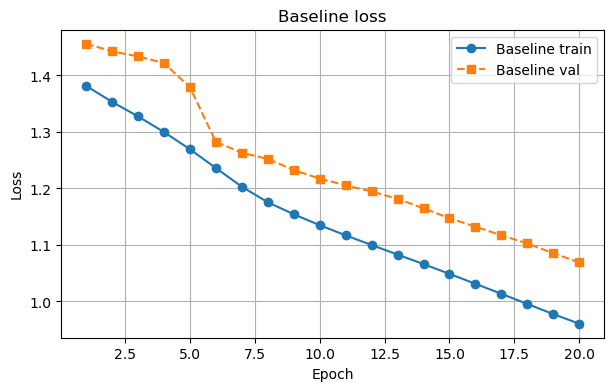


Evaluating baseline model n.0 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5036 - loss: 1.1509
_________________________________________________________________________

Training baseline model n.1 with random seed: 1312
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2830 - loss: 1.3991 - val_accuracy: 0.2333 - val_loss: 1.3754 - learning_rate: 1.0000e-04
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2447 - loss: 1.3631 - val_accuracy: 0.3067 - val_loss: 1.3566 - learning_rate: 1.0000e-04
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2823 - loss: 1.3406 - val_accuracy: 0.3667 - val_loss: 1.3407 - learning_rate: 1.0000e-04
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3153 - loss: 1.3156 - val_accuracy: 0.3667 - val_loss: 1.3264 - learning_rate: 1.0000e-04
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3529 - loss: 1.2826 - val_accuracy: 0.3800 - val_loss: 1.3317 - learning_

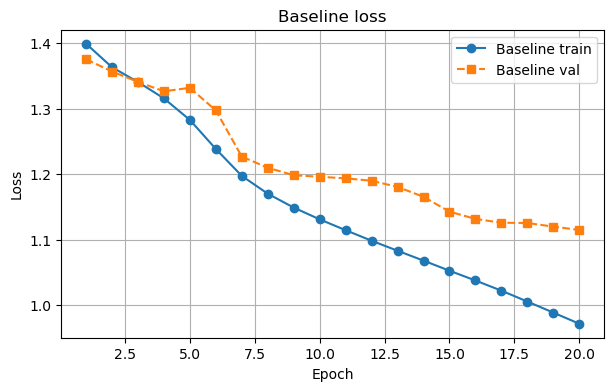


Evaluating baseline model n.1 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4821 - loss: 1.2010
_________________________________________________________________________

Training baseline model n.2 with random seed: 1234
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.2360 - loss: 1.3934 - val_accuracy: 0.2733 - val_loss: 1.3759 - learning_rate: 1.0000e-04
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2593 - loss: 1.3593 - val_accuracy: 0.3133 - val_loss: 1.3542 - learning_rate: 1.0000e-04
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2931 - loss: 1.3318 - val_accuracy: 0.3467 - val_loss: 1.3351 - learning_rate: 1.0000e-04
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.3237 - loss: 1.3033 - val_accuracy: 0.3667 - val_loss: 1.3144 - learning_rate: 1.0000e-04
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3648 - loss: 1.2749 - val_accuracy: 0.4533 - val_loss: 1.2899 - learning_

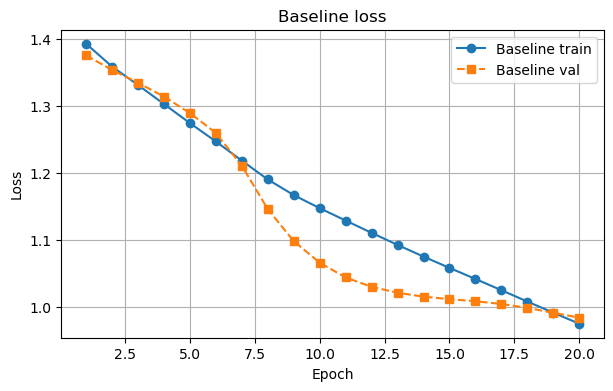


Evaluating baseline model n.2 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5536 - loss: 1.1280
_________________________________________________________________________


In [220]:

baseline = {}

baseline_acc_list = []
for i in range(len(seeds)):
    seed = seeds[i]
    print(f"\nTraining baseline model n.{i} with random seed: {seed}")
    set_seed(seed)

    baseline_ckpt = ModelCheckpoint(
        filepath='checkpoints/baseline_best'+str(i)+'.h5',  # or 'checkpoints/baseline_best' for SavedModel dir
        monitor='val_loss',                       # metric to monitor
        save_best_only=True,
        save_weights_only=False,                  # False -> save full model
        mode='min',                               # 'min' for val_loss, 'max' for val_accuracy
        verbose=1
    )

    baseline_callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        #baseline_ckpt
    ]
    
    # MODEL DEFINITION
    baseline[i] = build_baseline()

    baseline[i].compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    baseline[i].build(input_shape=(None, max_len))

    #training the model
    bl_history = baseline[i].fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        shuffle=True,
        class_weight=class_weight_dict,
        callbacks=baseline_callbacks,
        verbose=1
    )

    #baseline[i] = load_model('checkpoints/baseline_best'+str(i)+'.h5')
    plot_train_val_loss(bl_history, label='Baseline')

    print(f"\nEvaluating baseline model n.{i} on test set:")
    baseline_loss, baseline_acc = baseline[i].evaluate(X_test, y_test, batch_size=32)
    baseline_acc_list.append(baseline_acc)
    print('_________________________________________________________________________')

In [221]:
st_dev = np.std(baseline_acc_list)
print(f'Baseline Test Accuracy: {np.mean(baseline_acc_list):.4f} +/- {st_dev:.4f}')

Baseline Test Accuracy: 0.5131 +/- 0.0299


## Stacked Model Training


Training stacked model n.0 with random seed: 42
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.2367 - loss: 1.3769 - val_accuracy: 0.1067 - val_loss: 1.4561 - learning_rate: 1.0000e-04
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - accuracy: 0.3428 - loss: 1.3439 - val_accuracy: 0.2133 - val_loss: 1.4096 - learning_rate: 1.0000e-04
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.4250 - loss: 1.3005 - val_accuracy: 0.4800 - val_loss: 1.2787 - learning_rate: 1.0000e-04
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.4932 - loss: 1.2489 - val_accuracy: 0.5800 - val_loss: 1.1487 - learning_rate: 1.0000e-04
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.5169 - loss: 1.2083 - val_accuracy: 0.5933 - val_loss: 1.1188 - learning_rate: 1.0000e-04
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 0.5252 - loss: 1.1785 - val_accuracy: 0.5600 - val_loss: 1.1131 - learning_rate: 1.0000e-04
Epoch 7/20

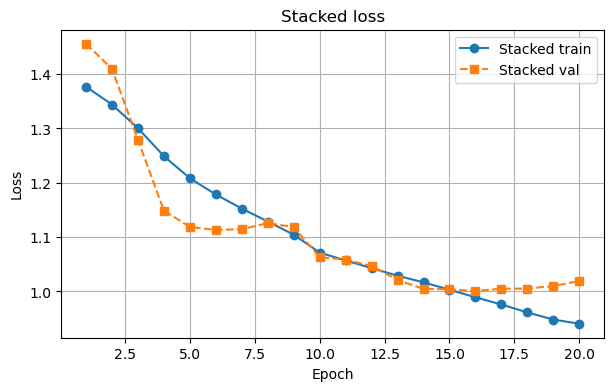


Evaluating stacked model n.0 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5393 - loss: 1.1005
_____________________________________________________________________________

Training stacked model n.1 with random seed: 1312
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 108ms/step - accuracy: 0.2238 - loss: 1.3854 - val_accuracy: 0.3000 - val_loss: 1.3668 - learning_rate: 1.0000e-04
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.2273 - loss: 1.3589 - val_accuracy: 0.3133 - val_loss: 1.3512 - learning_rate: 1.0000e-04
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.2732 - loss: 1.3268 - val_accuracy: 0.3133 - val_loss: 1.3433 - learning_rate: 1.0000e-04
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.3094 - loss: 1.2870 - val_accuracy: 0.3400 - val_loss: 1.3362 - learning_rate: 1.0000e-04
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.3735 - loss: 1.2441 - val_accuracy: 0.3533 - val_loss: 1.3107 - learn

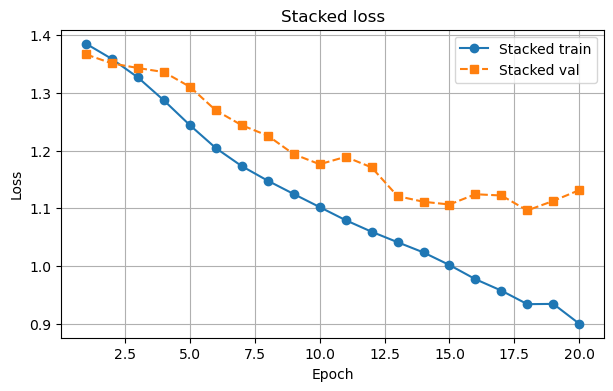


Evaluating stacked model n.1 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4929 - loss: 1.1801
_____________________________________________________________________________

Training stacked model n.2 with random seed: 1234
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.3261 - loss: 1.3943 - val_accuracy: 0.2000 - val_loss: 1.3808 - learning_rate: 1.0000e-04
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.2001 - loss: 1.3631 - val_accuracy: 0.2133 - val_loss: 1.3583 - learning_rate: 1.0000e-04
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.2788 - loss: 1.3313 - val_accuracy: 0.2867 - val_loss: 1.3363 - learning_rate: 1.0000e-04
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.3404 - loss: 1.2910 - val_accuracy: 0.3467 - val_loss: 1.3109 - learning_rate: 1.0000e-04
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.3947 - loss: 1.2536 - val_accuracy: 0.4133 - val_loss: 1.2776 - learni

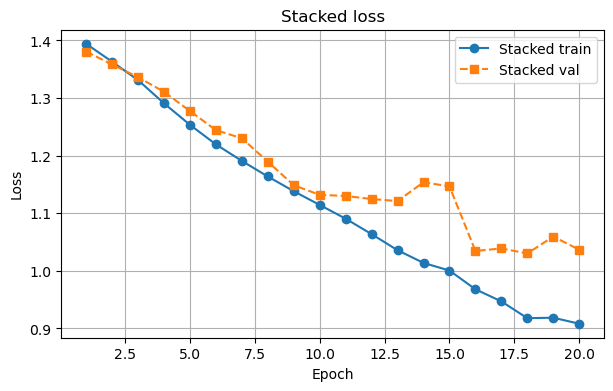


Evaluating stacked model n.2 on test set:
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.5286 - loss: 1.1095
_____________________________________________________________________________


In [222]:
stacked = {}

stacked_model_acc_list = []
for i in range(len(seeds)):
    seed = seeds[i]
    print(f"\nTraining stacked model n.{i} with random seed: {seed}")
    set_seed(seed)

    stacked_ckpt = ModelCheckpoint(
        filepath='checkpoints/stacked_best'+str(i)+'.h5',  # or 'checkpoints/stacked_best' for SavedModel dir
        monitor='val_loss',                       # metric to monitor
        save_best_only=True,
        save_weights_only=False,                  # False -> save full model
        mode='min',                               # 'min' for val_loss, 'max' for val_accuracy
        verbose=1
    )

    stacked_callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
        #stacked_ckpt
    ]

    # MODEL DEFINITION
    stacked[i] = build_stacked()
    
    stacked[i].compile(
        loss='sparse_categorical_crossentropy', 
        optimizer=Adam(learning_rate=lr),
        metrics=['accuracy']
    )

    stacked[i].build(input_shape=(None, max_len))

    #display(stacked[i].summary())
    
    #training the model
    st_history = stacked[i].fit(
        x=X_train,
        y=y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        shuffle=True,
        class_weight=class_weight_dict,
        callbacks=stacked_callbacks,
        verbose=1
    )

    # plot_train_val_loss(st_history, label='Stacked')
    #stacked[i] = load_model('checkpoints/stacked_best'+str(i)+'.h5')
    plot_train_val_loss(st_history, label='Stacked')

    print(f"\nEvaluating stacked model n.{i} on test set:")
    stacked_model_loss, stacked_model_acc = stacked[i].evaluate(X_test, y_test, batch_size=32)
    stacked_model_acc_list.append(stacked_model_acc)
    print('_____________________________________________________________________________')

In [223]:
st_dev = np.std(stacked_model_acc_list)
print(f'Stacked Test Accuracy: {np.mean(stacked_model_acc_list):.4f} +/- {st_dev:.4f}')

Stacked Test Accuracy: 0.5202 +/- 0.0198


Load and evaluate the models

In [224]:
from tensorflow.keras.models import load_model
stacked_best = load_model('checkpoints/stacked_best.h5')

In [225]:
stacked_loss, stacked_acc = stacked_best.evaluate(X_test, y_test, batch_size=32)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5571 - loss: 1.0456


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
- **Load the Tokenizer and Model**

- **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

- **Train the Model**:
   Use the `Trainer` to train the model on your training data.

- **Evaluate the Model on the Test Set** using the same metrics used for LSTM-based models.

In [226]:
import torch
print('cuda available: ', torch.cuda.is_available())

import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification, XLMRobertaTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import os
import accelerate

cuda available:  False


ModuleNotFoundError: No module named 'accelerate'

In [ ]:
# 1. Load Tokenizer from the 'base' model (where the vocab files actually exist)
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")

# 2. Load the Model from the 'hate' checkpoint
model_card = "cardiffnlp/twitter-roberta-base-hate"
model = AutoModelForSequenceClassification.from_pretrained(model_card)

print("Success: Tokenizer and Model loaded separately.")

Success: Tokenizer and Model loaded separately.


In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Tasks:
# emoji, emotion, hate, irony, offensive, sentiment
# stance/abortion, stance/atheism, stance/climate, stance/feminist, stance/hillary

task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base")

# For windows systems
new_save_directory = "./my_local_hate_model" 
# model.save_pretrained(new_save_directory)
# tokenizer.save_pretrained(new_save_directory)

# download label mapping
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(new_save_directory)

text = "Good night 😊"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

# # TF
# model = TFAutoModelForSequenceClassification.from_pretrained(MODEL)
# model.save_pretrained(MODEL)

# text = "Good night 😊"
# encoded_input = tokenizer(text, return_tensors='tf')
# output = model(encoded_input)
# scores = output[0][0].numpy()
# scores = softmax(scores)

ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = labels[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


1) not-hate 0.9168
2) hate 0.0832


In [ ]:
train_df = pd.read_csv('cleaned_train.csv')
val_df = pd.read_csv('cleaned_validation.csv')
test_df = pd.read_csv('cleaned_test.csv')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 2873
Validation samples: 150
Test samples: 280


In [ ]:
from datasets import Dataset

train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)
test_data = Dataset.from_pandas(test_df)

In [ ]:
def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True)

train_data = train_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched = True)
test_data = test_data.map(preprocess_text, batched=True)

Map: 100%|██████████| 280/280 [00:00<00:00, 9678.23 examples/s]


In [ ]:
print(train_data)
print(val_data)
print(test_data)
print(train_data['input_ids'][12][:200])
print(train_data['attention_mask'][12][:200])

original_text = train_data['tweet'][12]
decoded_text = tokenizer.decode(train_data['input_ids'][12])

print(original_text[:200])
print()
print()
print(decoded_text[:200])

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2873
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', 'input_ids', 'attention_mask'],
    num_rows: 150
})
Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'label', 'secondary', 'input_ids', 'attention_mask'],
    num_rows: 280
})
[0, 1990, 2512, 9, 768, 479, 905, 579, 386, 19, 5, 98, 486, 3959, 582, 4044, 19, 10, 3104, 7, 41, 15, 29, 1842, 479, 42, 1937, 28, 41, 1246, 9, 596, 28228, 28, 240, 479, 939, 385, 101, 7, 1606, 14, 66, 9, 27983, 21554, 4289, 129, 389, 28, 7923, 98, 24, 269, 28, 41, 696, 204, 195, 2]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
for yourself of course . let s start with the so call gender pay gap with a link to an ons page . this alone be an example of why feminism be need . i d like to add that out

'\nDo later: use the data before the preprocessing that we did.\n\n'

In [ ]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding

# --- 1. CONFIGURATION ---
model_card = "cardiffnlp/twitter-roberta-base-hate"
save_directory = "./final_sexism_model"  # <--- NEW: The permanent home for your fine-tuned model

# --- 2. LOGIC: CHECK FOR EXISTING MODEL ---
if os.path.exists(save_directory) and len(os.listdir(save_directory)) > 0:
    print(f"Found a saved model in '{save_directory}'. Loading it for inference...")
    
    # Load the model directly from your local folder
    model = AutoModelForSequenceClassification.from_pretrained(save_directory)
    
    # Set a flag to skip training
    should_train = False

else:
    print(f"No saved model found in '{save_directory}'. Loading base model for training...")
    
    # Load the base model from the Internet (Hugging Face Hub)
    # We use ignore_mismatched_sizes because we are likely changing the number of labels to 4
    model = AutoModelForSequenceClassification.from_pretrained(
        model_card, 
        num_labels=4, 
        ignore_mismatched_sizes=True,
        use_safetensors=True
    )
    
    # Set a flag to perform training
    should_train = True

Found a saved model in './final_sexism_model'. Loading it for inference...


In [ ]:
import evaluate

acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

In [ ]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)
    
    f1 = f1_metric.compute(predictions=predictions,
                           references=labels,
                           average='macro')
    acc = acc_metric.compute(predictions=predictions, 
                             references=labels)
    return {**f1, **acc}

In [ ]:
training_args = TrainingArguments(
    output_dir="test_dir",             # Checkpoints still go here
    learning_rate=2e-5,                  
    per_device_train_batch_size=8,     
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",             
    save_strategy="epoch",             
    load_best_model_at_end=True,
    report_to='none'                  
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

In [ ]:
if should_train:
    print("Starting training...")
    trainer.train()
    
    print(f"Training finished. Saving model to '{save_directory}'...")
    # CRITICAL STEP: Save the "best" model permanently so the 'if' statement works next time
    trainer.save_model(save_directory)
    tokenizer.save_pretrained(save_directory)
else:
    print("Skipping training. Model is ready for Error Analysis.")

Skipping training. Model is ready for Error Analysis.


# [Task 7 - 0.5 points] Error Analysis

After evaluating the model, perform a brief error analysis:

### Instructions

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.

## First step: confusion matrices

We start with plotting the confusion matrices of both the stacked model and the transformer results to evaluate false positive and false negatives.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define class names based on your mapping
# 0: '-', 1: 'DIRECT', 2: 'JUDGEMENTAL', 3: 'REPORTED'
class_names = ['-', 'DIRECT', 'JUDGEMENTAL', 'REPORTED']


# Confusion Matrix for LSTM Model
if 'stacked_best' in globals():
    print("Generating Confusion Matrix for LSTM Model...")
    
    # Get predictions on the test set
    y_pred_probs = stacked_best.predict(X_test)
    y_pred_lstm = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    cm_lstm = confusion_matrix(y_test, y_pred_lstm)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp_lstm = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=class_names)
    disp_lstm.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    ax.set_title("Confusion Matrix - Stacked LSTM")
    plt.show()
else:
    print("LSTM model 'stacked_best' not found in memory.")

# Confusion Matrix for Transformer Model
if 'trainer' in globals():
    print("\nGenerating Confusion Matrix for Transformer Model...")
    
    # Get predictions from the trainer on the test dataset
    output = trainer.predict(test_data)
    y_pred_transformer = np.argmax(output.predictions, axis=1)
    y_true_transformer = output.label_ids

    # Compute confusion matrix
    cm_transformer = confusion_matrix(y_true_transformer, y_pred_transformer)

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    disp_transformer = ConfusionMatrixDisplay(confusion_matrix=cm_transformer, display_labels=class_names)
    disp_transformer.plot(cmap=plt.cm.Greens, ax=ax, xticks_rotation='vertical')
    ax.set_title("Confusion Matrix - Transformer")
    plt.show()
else:
    print("Transformer 'trainer' not found in memory.")


LSTM model 'stacked_best' not found in memory.
Transformer 'trainer' not found in memory.


We can immediately notice how the stacked model, other than having worse accuracy, also shows a higher count of false positive (detected sexism when the label says there is none) compared to the more balanced output of the transformer.

# Step two: confidence vs accuracy

We plot the confidence (probability for a certain class from the inference) vs the accuracy, we do this so to understand how overfitting the models are.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

def plot_confidence_vs_accuracy(y_true, y_probs, title="Confidence vs Accuracy", n_bins=10):

    # Get predictions (argmax) and confidences (max probability)
    y_pred = np.argmax(y_probs, axis=1)
    confidences = np.max(y_probs, axis=1)
    
    # Check correctness of predictions (1 if correct, 0 if wrong)
    accuracies = (y_pred == y_true).astype(int)
    
    # Define bins
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_accs = []
    bin_confs = []
    
    for i in range(n_bins):
        lower = bin_edges[i]
        upper = bin_edges[i+1]
        
        # Handle the last bin to include 1.0 exactly
        if i == n_bins - 1:
            mask = (confidences >= lower) & (confidences <= upper)
        else:
            mask = (confidences >= lower) & (confidences < upper)
            
        # Only calculate if there are samples in this bin
        if np.sum(mask) > 0:
            bin_accs.append(np.mean(accuracies[mask]))
            bin_confs.append(np.mean(confidences[mask]))
            
    # Plotting
    plt.figure(figsize=(7, 6))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly Calibrated')
    plt.plot(bin_confs, bin_accs, marker='o', label='Model Performance')
    plt.xlabel('Average Confidence')
    plt.ylabel('Average Accuracy')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot for LSTM Model
if 'stacked_best' in globals():
    print("Generating Confidence vs Accuracy for LSTM Model...")
    # Get probabilities from the model
    y_probs_lstm = stacked_best.predict(X_test)
    plot_confidence_vs_accuracy(y_test, y_probs_lstm, title="Reliability Diagram - Stacked LSTM")
else:
    print("LSTM model 'stacked_best' not found in memory.")

# Plot for Transformer Model
if 'trainer' in globals():
    print("\nGenerating Confidence vs Accuracy for Transformer Model...")
    # Get logits from trainer and convert to probabilities using softmax
    output = trainer.predict(test_data)
    y_probs_transformer = softmax(output.predictions, axis=1)
    y_true_transformer = output.label_ids
    
    plot_confidence_vs_accuracy(y_true_transformer, y_probs_transformer, title="Reliability Diagram - Transformer")
else:
    print("Transformer 'trainer' not found in memory.")



LSTM model 'stacked_best' not found in memory.
Transformer 'trainer' not found in memory.


The resulted plots show how the Stacked model has a pretty linear response, we have a "honest" model. On the other hand, our Transformer model shows a relevant degree of overconfidence in several bins, symptom of possible overfitting.

## Step three: comparison of the misclassified samples with secondary labels
The hypothesis that our models might be misclassifying samples that have thin margin of confidence arose, so we analyzed the possibility that our models might be correctly predicting the second most voted class instead. 

In [ ]:
import pandas as pd
import numpy as np

def get_misclassified_samples(model, X, y_true, df, model_type='lstm', trainer=None):
    
    # Define inverse mapping for readability
    inv_mapping = {0: '-', 1: 'DIRECT', 2: 'JUDGEMENTAL', 3: 'REPORTED'}

    if model_type == 'lstm':
        # Get probabilities and convert to class indices
        y_pred_probs = model.predict(X, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
    elif model_type == 'transformer':
        if trainer is None:
            raise ValueError("Please provide the 'trainer' argument for Transformer models.")
        # Trainer.predict returns predictions (logits) and label_ids
        output = trainer.predict(X)
        y_pred = np.argmax(output.predictions, axis=1)
        y_true = output.label_ids
        
    else:
        raise ValueError("Invalid model_type. Choose 'lstm' or 'transformer'.")

    # Find indices where predictions do not match true labels
    error_indices = np.where(y_pred != y_true)[0]
    
    # Filter the original DataFrame using iloc to ensure alignment
    error_df = df.iloc[error_indices].copy()
    
    # Add prediction info
    # mapping indices to label strings
    error_df['true_label_id'] = y_true[error_indices]
    error_df['pred_label_id'] = y_pred[error_indices]
    error_df['true_label'] = error_df['true_label_id'].map(inv_mapping)
    error_df['pred_label'] = error_df['pred_label_id'].map(inv_mapping)

    return error_df

# Assuming 'baseline_model' is your trained Keras model
lstm_errors = get_misclassified_samples(
    model=stacked_best, 
    X=X_test, 
    y_true=y_test, 
    df=test_df, 
    model_type='lstm'
).copy()

# Display first few errors
# lstm_errors.to_csv('lstm_misclassified_samples.csv', index=False)



In [ ]:
# number of times the model predicted 'secondary' correctly
count = (lstm_errors['secondary_label'] == lstm_errors['pred_label']).sum()
count_all = len(lstm_errors)

print("LSTM Model:")
print(f"The number of samples that have been correctly predicted as belonging to the secondary class is {count} out of {count_all}" )

The number of samples that have been correctly predicted as belonging to the secondary class is 37 out of 124


We obtain that in 37 out of 124 samples (circa 30) have been only partially misclassified, as the secondary label was correctly recognized by the stacked model.

In [ ]:
lstm_true_error = lstm_errors[lstm_errors['secondary_label'] != lstm_errors['pred_label']].copy()


Now we peek inside the truly misclassified samples to try to understand the misclassification causes:

In [ ]:
def get_tweet_text(id_num):
    # Ensure we look for the string version if your IDs are strings
    match = df_test_en[df_test_en['id_EXIST'] == str(id_num)]
    if not match.empty:
        return match['tweet'].values[0]
    return None # Handle cases where ID might be missing

# Use a lambda to apply the function row by row
lstm_true_error['original_tweet'] = lstm_true_error['id_EXIST'].apply(lambda x: get_tweet_text(x))

In [ ]:
def og_tweet(id_num, df):
    tweet = df[df['id_EXIST'] == str(id_num)]['tweet'].values[0]
    return tweet

lstm_true_error['original_tweet'] = lstm_true_error['id_EXIST'].apply(lambda x: og_tweet(x, df_test_en))

In [ ]:
lstm_true_error_disp = lstm_true_error.drop(columns=['true_label_id', 'pred_label_id', 'label'])
new_order = ['id_EXIST', 'tweet', 'pred_label', 'true_label', 'secondary_label', 'original_tweet']
lstm_true_error_disp = lstm_true_error_disp.loc[:, new_order]
lstm_true_error_disp.head()

,id_EXIST,lang,tweet,label,secondary,true_label_id,pred_label_id,true_label_str,pred_label_str,original_tweet
6,400186,en,maybe something involve her get gangbanged ?,1,REPORTED,1,0,DIRECT,-,@Fox_x_Gods Maybe something involving her gett...
13,400194,en,the violent antifeminism of a far right moveme...,3,DIRECT,3,0,REPORTED,-,"""The violent antifeminism of a far-right movem..."
14,400195,en,ah ! look ! gender role be back too ! the don ...,1,JUDGEMENTAL,1,0,DIRECT,-,@MrsGreyBull @Miriam2626 Ah! Look! Gender role...
15,400196,en,yes hayley hafu representation give our japane...,0,JUDGEMENTAL,0,1,-,DIRECT,@earth2kayla yes hayley hafu representation gi...
18,400199,en,how do we reach a point where blonks be have t...,0,DIRECT,0,2,-,JUDGEMENTAL,@EyemotionFandom How did we reach a point wher...


In [ ]:
# Analyze Transformer Errors
print("Generating Transformer Errors...")

# Call the function with model_type='transformer' and pass the trainer
transformer_errors = get_misclassified_samples(
    model=None,              # Not needed for transformer (uses trainer)
    X=test_data,             # The Hugging Face dataset
    y_true=None,             # Labels are extracted from the trainer output
    df=test_df,              # Original dataframe to retrieve text
    model_type='transformer',
    trainer=trainer          # The Hugging Face Trainer instance
)

# number of times the model predicted 'secondary' correctly
count = (transformer_errors['secondary'] == transformer_errors['pred_label_str']).sum()
count_all = len(transformer_errors)

print("Transformer Model:")
print(f"The number of samples that have been correctly predicted as belonging to the secondary class is {count} out of {count_all}" )

transformer_true_error = transformer_errors[transformer_errors['secondary'] != transformer_errors['pred_label_str']].copy()




Generating Transformer Errors...


c:\Users\dales\miniconda3\envs\nlp_env\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Transformer Model:
The number of samples that have been correctly predicted as belonging to the secondary class is 27 out of 71


In [ ]:
# Defining common errors for both models

common_errors = pd.merge(lstm_errors, transformer_errors, on='id_EXIST', how = 'inner', suffixes=('_lstm', '_transformer'))

In [ ]:
common_errors.to_csv('common_misclassified_samples.csv', index=False)

In [ ]:
# lstm_true_error.to_csv('lstm_true_misclassified_samples.csv', index=False)

In [ ]:
# Use a lambda to apply the function row by row
transformer_true_error['original_tweet'] = transformer_true_error['id_EXIST'].apply(lambda x: get_tweet_text(x))
transformer_true_error.head()


,id_EXIST,lang,tweet,label,secondary,true_label_id,pred_label_id,true_label_str,pred_label_str,original_tweet
8,400188,en,kabul islamic emirate of afghanistan ha announ...,3,DIRECT,3,0,REPORTED,-,@BBCYaldaHakim Kabul: Islamic Emirate of Afgha...
13,400194,en,the violent antifeminism of a far right moveme...,3,DIRECT,3,0,REPORTED,-,"""The violent antifeminism of a far-right movem..."
14,400195,en,ah ! look ! gender role be back too ! the don ...,1,JUDGEMENTAL,1,0,DIRECT,-,@MrsGreyBull @Miriam2626 Ah! Look! Gender role...
20,400201,en,hot girl can t get nowhere without a gps,1,JUDGEMENTAL,1,0,DIRECT,-,Hot girls can’t get nowhere without a GPS
40,400225,en,wait till ur husband mess up u gon na love the...,1,JUDGEMENTAL,1,0,DIRECT,-,@reebecatavares Wait till ur husband messes up...


In [ ]:
transformer_true_error.to_csv('transformer_true_misclassified_samples.csv', index=False)

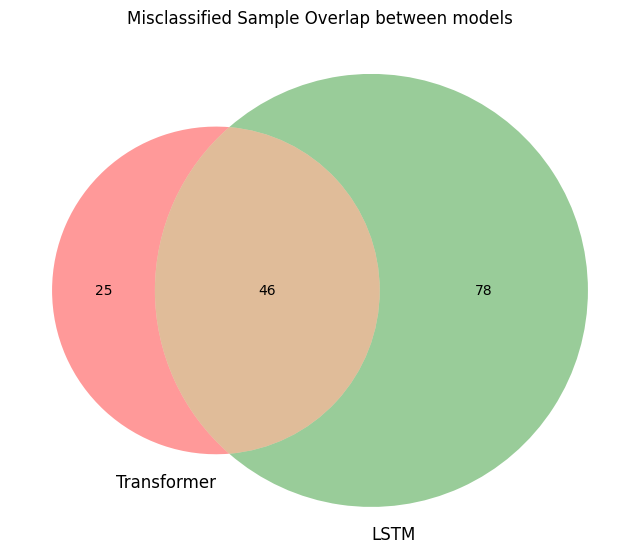

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Assume the column 'id_EXIST' is your unique identifier
ids_df1 = set(transformer_errors['id_EXIST'])
ids_df2 = set(lstm_errors['id_EXIST'])

plt.figure(figsize=(8, 8))
venn2([ids_df1, ids_df2], set_labels=('Transformer', 'LSTM'))
plt.title("Misclassified Sample Overlap between models")
plt.show()

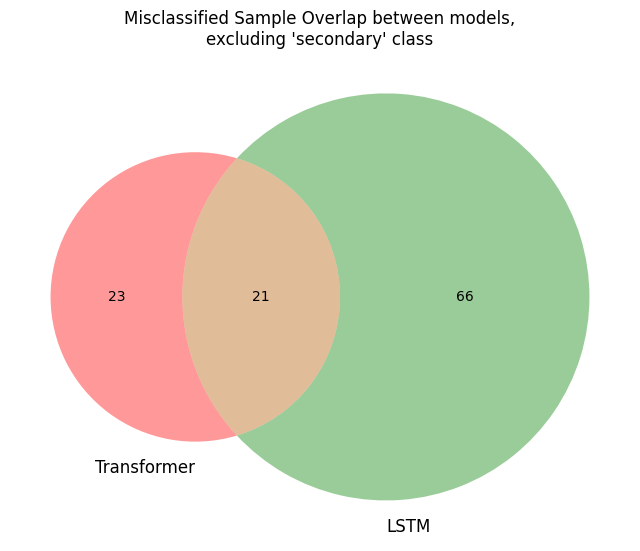

In [ ]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Assume the column 'id_EXIST' is your unique identifier
ids_df1 = set(transformer_true_error['id_EXIST'])
ids_df2 = set(lstm_true_error['id_EXIST'])

plt.figure(figsize=(8, 8))
venn2([ids_df1, ids_df2], set_labels=('Transformer', 'LSTM'))
plt.title("Misclassified Sample Overlap between models,\nexcluding 'secondary' class")
plt.show()

There is the possibility that our lstm model doesn't recognize many of the words used since they might not appear in the vocabulary or might have never been seen during training:


In [ ]:
def check_tweet_oov(id_exist, verbose = True):
    """
    Analyzes a tweet by ID to find words that are Out-Of-Vocabulary (OOV).
    Checks against:
    1. The model's vocabulary (word_to_idx) -> These become <UNK>
    2. The GloVe embeddings (embedding_model) -> These get random vectors if in vocab, or <UNK>
    """
    tweet_text = None
    dataset_name = ""
    
    # Search for the tweet in all datasets
    # We cast ID to string to ensure matching works regardless of type (int/str)
    search_id = str(id_exist)
    
    # Ensure these dataframes are the ones with CLEANED text (from Task 2/3)
    datasets = [("Train", train_df), ("Validation", val_df), ("Test", test_df)]
    
    for name, df in datasets:
        if 'id_EXIST' in df.columns:
            row = df[df['id_EXIST'].astype(str) == search_id]
            if not row.empty:
                tweet_text = row.iloc[0]['tweet']
                dataset_name = name
                break
    
    if tweet_text is None:
        print(f"Tweet with ID {id_exist} not found in Train, Validation, or Test sets.")
        return

    if verbose:
        print(f"--- Analysis for Tweet ID: {id_exist} ({dataset_name} Set) ---")
        print(f"Cleaned Text: \"{tweet_text}\"")
    
    # Tokenize (assuming space-separated tokens as per your preprocessing)
    tokens = str(tweet_text).split()
    
    # 1. Check Model OOV
    # Words not in word_to_idx are mapped to the <UNK> token during encoding.
    # These are the most critical OOVs as the model sees them all as the same unknown token.
    model_oovs = [t for t in tokens if t not in word_to_idx]
    
    # 2. Check GloVe OOV
    # Words not in GloVe but in word_to_idx were initialized with random vectors.
    # Words not in GloVe and not in word_to_idx are <UNK>.
    glove_oovs = []
    if 'embedding_model' in globals():
        glove_oovs = [t for t in tokens if t not in embedding_model.key_to_index]

    if verbose:    
        print(f"\nTotal Tokens: {len(tokens)}")
        
        print(f"\n[Model OOV] Words mapped to <UNK> ({len(model_oovs)}):")
        print(model_oovs if model_oovs else "None")
        if 'embedding_model' in globals():
            print(f"\n[GloVe OOV] Words without pre-trained embeddings ({len(glove_oovs)}):")
            print(glove_oovs if glove_oovs else "None")
        else:
            print("\n[GloVe OOV] embedding_model not found in memory, skipping check.")
    return model_oovs, glove_oovs
# Example usage with an ID from your error analysis
# check_tweet_oov(400186)


In [ ]:
check_tweet_oov(400194)

--- Analysis for Tweet ID: 400194 (Test Set) ---
Cleaned Text: "the violent antifeminism of a far right movement that see principally a vessel for breed a new white generation express itself in a fixation on a return to traditional gender role worth every minute to read take 5 min out of your sun"

Total Tokens: 43

[Model OOV] Words mapped to <UNK> (3):
['antifeminism', 'principally', 'fixation']

[GloVe OOV] Words without pre-trained embeddings (1):
['antifeminism']


(['antifeminism', 'principally', 'fixation'], ['antifeminism'])

In [ ]:
model_oov_count = 0
glove_oov_count = 0
uneffected_count = 0

model_oov_array = []
glove_oov_array = []
for tweet_id in lstm_true_error['id_EXIST']:
    model_oovs, glove_oovs = check_tweet_oov(tweet_id, verbose=False)
    model_oov_count += len(model_oovs)
    glove_oov_count += len(glove_oovs)
    if len(model_oovs)==0 and len(glove_oovs)==0:
        uneffected_count += 1
    else:
        model_oov_array.append((tweet_id, model_oovs))
        glove_oov_array.append((tweet_id, glove_oovs))
print(f"Total Model OOVs in LSTM true errors: {model_oov_count}")
print(f"Total GloVe OOVs in LSTM true errors: {glove_oov_count}")
print(f"Number of tweets with no OOVs in LSTM true errors: {uneffected_count} out of {len(lstm_true_error)}")


Total Model OOVs in LSTM true errors: 148
Total GloVe OOVs in LSTM true errors: 40
Number of tweets with no OOVs in LSTM true errors: 23 out of 87


Our LSTM model does not recognize many words apparently, this could be the possible cause for at most 64 misclassified samples.

In [ ]:
for i in model_oov_array:
    print(i)

(400186, [])
(400194, ['antifeminism', 'principally', 'fixation'])
(400196, ['hayley', 'hafu', 'japanese', 'hispanic'])
(400199, ['blonks', 'audacity', 'yoongis', 'stan', 'lyricism'])
(400205, ['testicle'])
(400208, ['yeshua', 'devil', 'synagogue', 'satan', 'sheep'])
(400210, ['douche', 'nozzle', 'moses', 'inquisitor', 'badassary'])
(400215, ['Cre8tiveCon', 'disciple'])
(400235, ['serial', 'soley'])
(400243, ['louisiana', 'opportunistic', 'yokel'])
(400255, ['guitar'])
(400256, ['certificate'])
(400258, ['transwoman', 'unpack'])
(400267, ['initially'])
(400286, ['chara', 'flirty', 'digimon'])
(400292, ['pluralistic', 'furthermore', 'whatsoever'])
(400294, ['swede', 'survivalism'])
(400296, ['exploit'])
(400297, ['galaxy', 'menswear', 'stylish', 'lesbicious'])
(400302, ['gatheringeconomic', 'sytems', 'kinship', 'dominance'])
(400304, ['teaxass', 'diseased'])
(400308, [])
(400309, ['dicklet', 'clitoris', 'phallic', 'plurality', 'coexist', 'phallic'])
(400321, ['squirt'])
(400324, ['ovula

In [ ]:
for i in glove_oov_array:
    print(i)

(400186, ['gangbanged'])
(400194, ['antifeminism'])
(400196, ['hafu'])
(400199, ['blonks', 'yoongis'])
(400205, [])
(400208, [])
(400210, ['badassary'])
(400215, ['Cre8tiveCon'])
(400235, [])
(400243, [])
(400255, ['manspreading'])
(400256, [])
(400258, ['transwoman'])
(400267, [])
(400286, ['tbh'])
(400292, [])
(400294, [])
(400296, [])
(400297, ['lesbicious'])
(400302, ['gatheringeconomic', 'patrilocal'])
(400304, ['teaxass'])
(400308, ['phallocentrism'])
(400309, ['dicklet', 'phallocentrism', 'clit', 'clit'])
(400321, [])
(400324, [])
(400327, ['anyones'])
(400332, [])
(400339, [])
(400345, ['soand', 'motherfúckers'])
(400347, [])
(400348, [])
(400351, [])
(400356, [])
(400366, [])
(400374, ['slutbag'])
(400379, [])
(400380, ['typa'])
(400384, ['pomlázka'])
(400385, ['chavvy'])
(400386, [])
(400396, [])
(400400, [])
(400408, ['bounceeyy', 'boobieess'])
(400428, ['kneehighs'])
(400430, [])
(400431, [])
(400440, [])
(400445, ['femism'])
(400446, [])
(400450, [])
(400453, [])
(400455, 

Looking at the OOV from the model and from the GloVe we can see that many are insults or semantically significant (in the sexism context) words. This would explain many of the misclassifications.

In [ ]:
print(og_tweet(400304, df_test_en))
print("---")
print(og_tweet(400194, df_test_en))
print("---")
print(og_tweet(400199, df_test_en))
print("---")
print(og_tweet(400309, df_test_en))
print("---")
print(og_tweet(400210, df_test_en))

@BetteMidler It’s in the TEAxASS code book of penis envy idiots that it’s guns over everything. Sad thing is it’s spreading and the more we try to stop it, the faster it spreads like the diseased idiots that support it.
---
"The violent antifeminism of a far-right movement that sees ♀️ principally as vessels for breeding a new white generation expresses itself in a fixation on a return to “traditional” gender roles"Worth every minute to read - take 5 min out of your Sun👇https://t.co/zkdWPpIlzZ
---
@EyemotionFandom How did we reach a point where blonks are having the audacity to talk about yoongis rap do y'all see who you Stan ? Are y'all ok ?? Your girls can't write can't deliver can't come close to bts's lyricism tf are y'all getting brave for ?? Fashion deals ??
---
Freud claims girls have a dicklet. The clitoris has phallic significance. Phallocentrism reduces even female genitalia to the Phallus. The other parts of the vagina, the clit, and more constitute the plurality of female s

Analyzing the original tweets of some of the misclassified samples that present OOVs we can also notice another details: often the context is lost and these tweets seem aribtrarious and confused, referring to conversations that are not reported or events that are unknown to the reader and to the network.

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is **not a copy-paste** of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

## Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions

**Note**: bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Suggestions for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 5 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Expected Results

Task 2 leaderboard reports around 40-50 F1-score.
However, note that they perform a hierarchical classification.

That said, results around 30-40 F1-score are **expected** given the task's complexity.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.


# The End

Feel free to reach out for questions/doubts!